In [14]:
import open3d as o3d
import numpy as np
import json
from pathlib import Path
from scipy.spatial.transform import Rotation
from scipy.spatial import KDTree
from matplotlib import pyplot as plt
from matplotlib import animation
import time
import shutil
from tqdm import tqdm


## Load in data

Grab the transform and point cloud data from the data folder in order to animate it. Note that the point clouds are stored in homogeneous coordinates

In [15]:
# rust_path = Path("/Users/chrisvail/Desktop/icp/examples/output/transforms")
rust_path = Path("/Users/chrisvail/Documents/CruxTest/matcher/examples/output/transforms")
transform_root = Path("./data/transforms/")

for f in sorted(rust_path.glob("*.json"), key=lambda x: int(x.stem[6:])):
    shutil.copyfile(f, transform_root / f.name)

In [16]:
params = []

for file in sorted(transform_root.glob("*.json"), key=lambda x: int(x.stem[6:])):
    with open(file, "r") as f:
        params.append(np.array(json.load(f)))

In [17]:
def convert_params(x: np.array) -> np.array:
    rot = Rotation.from_euler("XYZ", x[3:])
    t = x[:3]

    rtn = np.eye(4)
    rtn[:3, :3] = rot.as_matrix()
    rtn[:3, -1] = t

    return rtn

transforms = [np.apply_along_axis(convert_params, 1, x) for x in params]

transforms[0].shape

(41, 4, 4)

In [18]:
pc_root = Path("./data/frames/")

pcs = []

for file in sorted(pc_root.glob("*.npy"), key=lambda x: int(x.stem[6:])):
    pc = np.load(file)
    pc = np.concatenate((pc, np.ones((pc.shape[0], 1))), 1)
    pcs.append(pc)

len(pcs), pcs[0].shape

(36, (187535, 4))

## Visualising the point cloud to make sure they make sense


In [19]:
# fig = plt.figure(figsize=(10,15))
# num_plots = 1
# rows, cols = 1, 1

plot_transform = np.eye(4)
plot_transform[:3, :3] = Rotation.from_euler("ZYX", [0, 0, -np.pi/2]).as_matrix()

# idxs = np.random.choice([x for x in range(len(pcs))], num_plots)
# print(idxs)

# for i, idx in enumerate(idxs):
#     pc = pcs[idx].copy()
#     # (4, 4) @ (n, 4, 1)
#     pc = plot_transform@pc[..., None]

#     ax = fig.add_subplot(cols, rows, i + 1, projection="3d")
#     ax.set_box_aspect((np.ptp(pc[:,0]), np.ptp(pc[:,1]), np.ptp(pc[:,2])))
#     ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=0.01)
#     ax.set_xlabel("X")
#     ax.set_ylabel("Y")
#     ax.set_zlabel("Z")

# plt.show()



## Animation
Here we're going to attempt to animate the ICP process using matplotlib which is going to be interesting to say the least

In [20]:
pcs[0][np.random.choice(range(pcs[0].shape[0]), 2**4)]

array([[-0.07653614, -0.04848332,  0.18019557,  1.        ],
       [-0.06969082,  0.15680821,  0.21199766,  1.        ],
       [-0.03563405,  0.00767663,  0.16753203,  1.        ],
       [-0.06462837, -0.04108863,  0.17158046,  1.        ],
       [-0.03203847, -0.03409863,  0.17312746,  1.        ],
       [-0.02369995,  0.09167413,  0.17747171,  1.        ],
       [-0.03190909, -0.03174108,  0.17246903,  1.        ],
       [-0.06127016, -0.05312949,  0.1798275 ,  1.        ],
       [-0.06097674,  0.03182007,  0.17638558,  1.        ],
       [-0.09946562,  0.1153169 ,  0.19850895,  1.        ],
       [-0.01842892,  0.13700886,  0.20180577,  1.        ],
       [-0.121582  ,  0.10803832,  0.21167196,  1.        ],
       [-0.08207197,  0.03188103,  0.17508079,  1.        ],
       [ 0.01029182, -0.04256314,  0.21344788,  1.        ],
       [-0.05757494,  0.06765959,  0.17522265,  1.        ],
       [-0.09517037,  0.02053006,  0.17782038,  1.        ]])

(145750, 4) (154861, 4) (41, 4, 4)


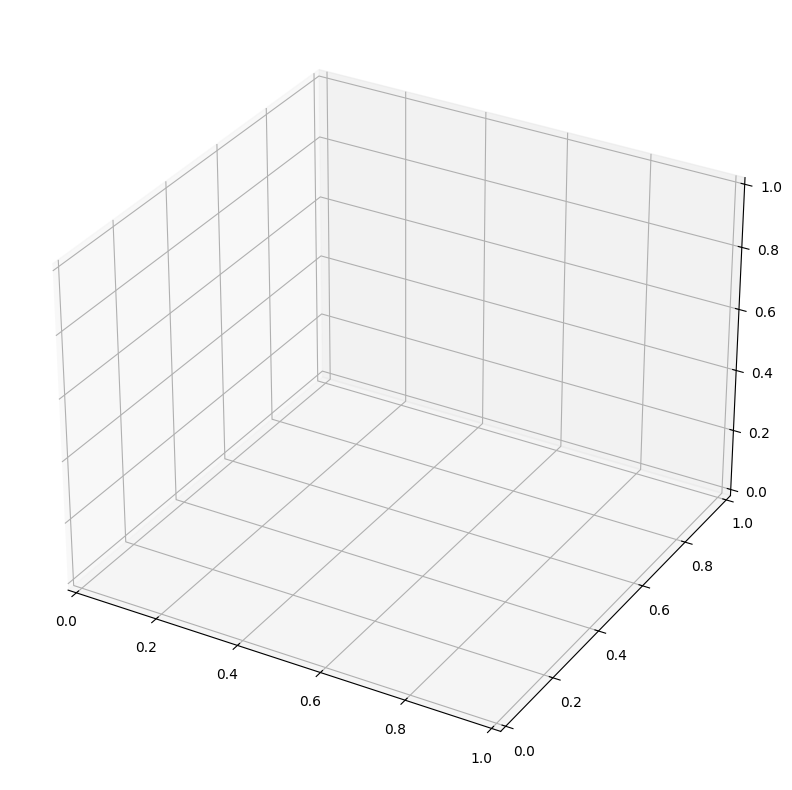

In [21]:
from typing import Any


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection="3d")


def init():
    return ()

class Animator:
    def __init__(self, source, target, transforms, fig, ax, plot_transform):
        self.source = source
        self.target = target
        self.transforms = transforms
        self.fig = fig
        self.ax = ax
        self.plot_transform = plot_transform

    def __call__(self, i) -> tuple[Any]:
        tree = KDTree(self.target[:,:3])
        samples = self.source[np.random.choice(self.source.shape[0], 2**14),:3]
        rmse = np.sqrt((np.array(tree.query(samples)[0])**2).mean())
        frob = np.linalg.norm(np.eye(4) - self.transforms[i], ord='fro')
        print(f"<{i}> Fro Norm: {frob} \tRMSE: {rmse*1000}mm")
        ax.clear()
        source = self.source[..., None]
        source = self.plot_transform@source

        ax.scatter(source[:, 0], source[:, 1], source[:, 2], s=0.005, c="b")
        
        target = self.target[..., None]
        target = self.transforms[i]@target
        target = self.plot_transform@target

        ax.scatter(target[:, 0], target[:, 1], target[:, 2], s=0.005, c="r")

        tot = np.concatenate((target, source), 0)

        ax.set_box_aspect((np.ptp(tot[:,0]), np.ptp(tot[:,1]), np.ptp(tot[:,2])))


# transforms_fake = np.array([np.eye(4), plot_transform, plot_transform@plot_transform, plot_transform@plot_transform@plot_transform])
# print(transforms_fake.shape)
# transforms_fake = np.concatenate((transforms_fake, transforms_fake, transforms_fake, transforms_fake), axis=0)
# print(transforms_fake.shape)


start = 16
print(pcs[start].shape, pcs[start + 1].shape, transforms[start].shape)

animator = Animator(pcs[start], pcs[start + 1], transforms[start], fig, ax, plot_transform)

# anim = animation.FuncAnimation(animator.fig, animator, len(transforms[start]))

# anim.save(Path(f"./icp_test_{time.strftime('%Y_%m_%d-%H_%M_%S')}.mp4"), fps=10)

Animation length: 385
<0>
<0>
<1>
<2>
<3>
<4>
<5>
<6>
<7>
<8>
<9>
<10>
<11>
<12>
<13>
<14>
<15>
<16>
<17>
<18>
<19>
<20>
<21>
<22>
<23>
<24>
<25>
<26>
<27>
<28>
<29>
<30>
<31>
<32>
<33>
<34>
<35>
<36>
<37>
<38>
<39>
<40>
<41>
<42>
<43>
<44>
<45>
<46>
<47>
<48>
<49>
<50>
<51>
<52>
<53>
<54>
<55>
<56>
<57>
<58>
<59>
<60>
<61>
<62>
<63>
<64>
<65>
<66>
<67>
<68>
<69>
<70>
<71>
<72>
<73>
<74>
<75>
<76>
<77>
<78>
<79>
<80>
<81>
<82>
<83>
<84>
<85>
<86>
<87>
<88>
<89>
<90>
<91>
<92>
<93>
<94>
<95>
<96>
<97>
<98>
<99>
<100>
<101>
<102>
<103>
<104>
<105>
<106>
<107>
<108>
<109>
<110>
<111>
<112>
<113>
<114>
<115>
<116>
<117>
<118>
<119>
<120>
<121>
<122>
<123>
<124>
<125>
<126>
<127>
<128>
<129>
<130>
<131>
<132>
<133>
<134>
<135>
<136>
<137>
<138>
<139>
<140>
<141>
<142>
<143>
<144>
<145>
<146>
<147>
<148>
<149>
<150>
<151>
<152>
<153>
<154>
<155>
<156>
<157>
<158>
<159>
<160>
<161>
<162>
<163>
<164>
<165>
<166>
<167>
<168>
<169>
<170>
<171>
<172>
<173>
<174>
<175>
<176>
<177>
<178>
<179>
<180

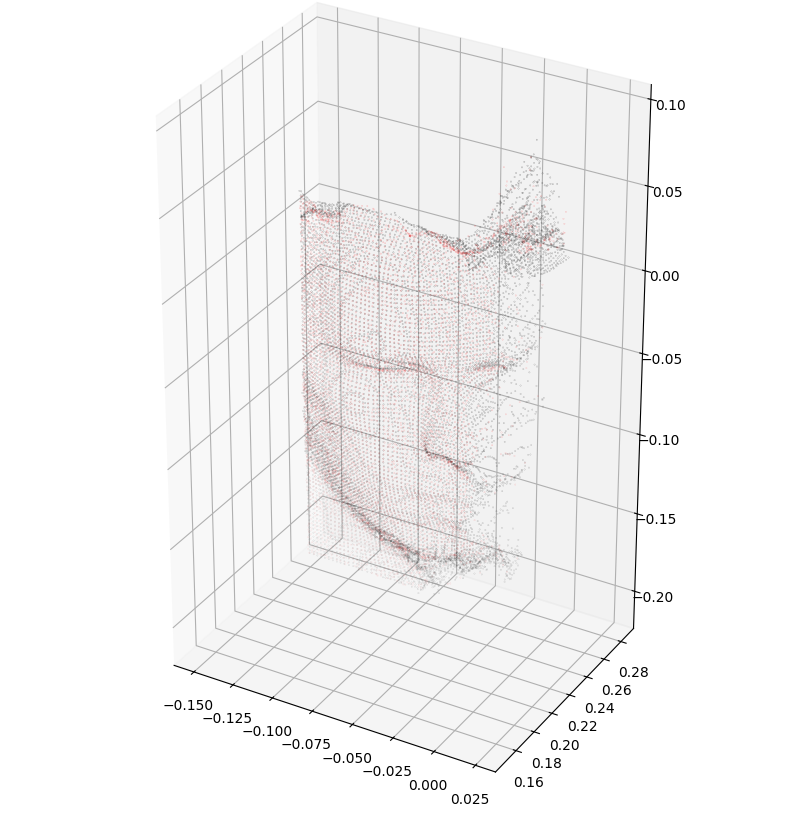

In [22]:
from copy import deepcopy
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection="3d")


def init():
    return ()

class FullAnimator:
    def __init__(self, pcs, transforms, fig, ax, plot_transform):
        self.pcs = pcs
        self.transforms = transforms
        self.fig = fig
        self.ax = ax
        self.plot_transform = plot_transform
        self.transform_len = transforms[0].shape[0]

        self.targets = self.get_targets()
        self.mins = np.min(self.targets[-1], 0)
        self.maxs = np.max(self.targets[-1], 0)
        self.ptp = (np.ptp(self.targets[-1][:,0]), np.ptp(self.targets[-1][:,1]), np.ptp(self.targets[-1][:,2]))        

    def __call__(self, i) -> tuple[Any]:

        start, transform_num = i // self.transform_len, i % self.transform_len
        transform = self.transforms[start][transform_num]
        target = deepcopy(self.targets[start][:,:])
        source = deepcopy(self.pcs[start + 1])

        print(f"<{i}>")

        ax.clear()
        source = FullAnimator.down_sample(self.plot_transform@transform@source[...,None], 1E-3)
        ax.scatter(source[:, 0], source[:, 1], source[:, 2], s=0.01, c="k")

        ax.scatter(target[:, 0], target[:, 1], target[:, 2], s=0.005, c="r")
        ax.set_box_aspect(self.ptp)
        ax.set_xlim(self.mins[0], self.maxs[0])
        ax.set_ylim(self.mins[1], self.maxs[1])
        ax.set_zlim(self.mins[2], self.maxs[2])

    def get_targets(self, samples_per_frame=2**14):
        targets = []
        target = None
        for i, pc in enumerate(self.pcs[:-1]):
            if target is None:
                target = (self.plot_transform@pc[np.random.choice(pc.shape[0], samples_per_frame),:,None]).squeeze()
                targets.append(target[:,:])
            else:
                points = (self.plot_transform@self.transforms[i - 1][-1]@pc[np.random.choice(pc.shape[0], samples_per_frame),:,None]).squeeze()
                target = np.concatenate((target, points), 0)
                targets.append(target[:,:])

        
        
        return [FullAnimator.down_sample(t) for t in targets]

    def down_sample(t, voxel_size=2.5E-3):
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(t[:,:3])
        cloud = cloud.voxel_down_sample(2.5E-3)
        return np.asarray(cloud.points)
                
    def __len__(self):
        return (len(self.pcs) - 1)*self.transform_len


# print(transforms[0].shape, transforms[4].shape, plot_transform.shape)
# animator = FullAnimator(pcs, transforms[:], fig, ax, plot_transform)
# animator = FullAnimator(pcs, [x[40:] for x in transforms], fig, ax, plot_transform)
animator = FullAnimator(pcs, [x[::4] for x in transforms], fig, ax, plot_transform)
print(f"Animation length: {len(animator)}")

anim = animation.FuncAnimation(animator.fig, animator, len(animator))

anim.save(Path(f"./videos/icp_test_{time.strftime('%Y_%m_%d-%H_%M_%S')}.mp4"), fps=20)

In [23]:
a = o3d.geometry.PointCloud()
p = np.random.randn(8,3)
a.points = o3d.utility.Vector3dVector(p)
b = a.voxel_down_sample(2.5E-3)
np.asarray(b.points).shape

(8, 3)